# Fuel efficiency prediction project

The goal of this notebook is to demonstrate the practical use of concepts presented in previous presentations on a real dataset, going through all the necessary steps of data loading, exploratory analysis and cleaning, building and training a model, and finally - evaluating the results.

## The dataset

Dataset used in this project is Auto MPG, which describes city-cycle fuel consumption of automobiles from the turn of 70s/80s decades.

The attributes that can be found in the data:

1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance)

Dataset URL on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/auto+mpg

In [8]:
# Define the dataset source and local filename
dataset_source_url = "https://archive.ics.uci.edu/" + \
                     "ml/machine-learning-databases/" + \
                     "auto-mpg/auto-mpg.data"
filename = dataset_source_url.split("/")[-1] or "auto-mpg.data"

In [9]:
# Import requests to download the dataset
import requests

response = requests.get(dataset_source_url)
response.raise_for_status()

with open(filename, "wb") as f:
    f.write(response.content)

print(f"Succesfully downloaded dataset to file: {filename}")

Succesfully downloaded dataset to file: auto-mpg.data


In [10]:
# Import pandas library
import pandas as pd


# Read the dataset
column_names = [
    "mpg", "cylinders", "displacement", "horsepower", 
    "weight", "acceleration", "model_year", "origin"
]

dataset_raw = pd.read_csv(
    filepath_or_buffer=filename, # name of file containing data
    names=column_names, # list of column names
    comment="\t", # treats car model column as comment whic means
                  # that it won't be read as data
    sep=" ", # delimiter to use
    skipinitialspace=True, # skip spaces after delimiter
    na_values="?" # character used for missing values
)

# Show first five rows
dataset_raw.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [11]:
# Create copy of the dataset that we can operate on
dataset = dataset_raw.copy()

# Show number of missing values for each column
dataset.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64

In [12]:
# Remove missing values, use inplace to modify existing dataframe
dataset.dropna(inplace=True)

# Show number of missing values for each column, again
dataset.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64

In [13]:
# We must encode 'origin' column, because it's categorical feature.
# Categorical features shouldn't be left as simple discrete integer values
# because there's no actual, numeric relations between categories encoded as int
# example - if USA is 1 and Japan is 3 it doesn't mean that Japan is somehow 
# two units apart from USE, or greater than it.

# First, let's see how many different origin categories do we have
dataset['origin'].unique().tolist()

[1, 3, 2]

In [14]:
# This category split can be achieved by Pandas feature of "creating dummies"
dataset_encoded = pd.get_dummies(dataset, columns=['origin'], prefix='origin')
dataset_encoded.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_1,origin_2,origin_3
393,27.0,4,140.0,86.0,2790.0,15.6,82,True,False,False
394,44.0,4,97.0,52.0,2130.0,24.6,82,False,True,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,True,False,False
396,28.0,4,120.0,79.0,2625.0,18.6,82,True,False,False
397,31.0,4,119.0,82.0,2720.0,19.4,82,True,False,False


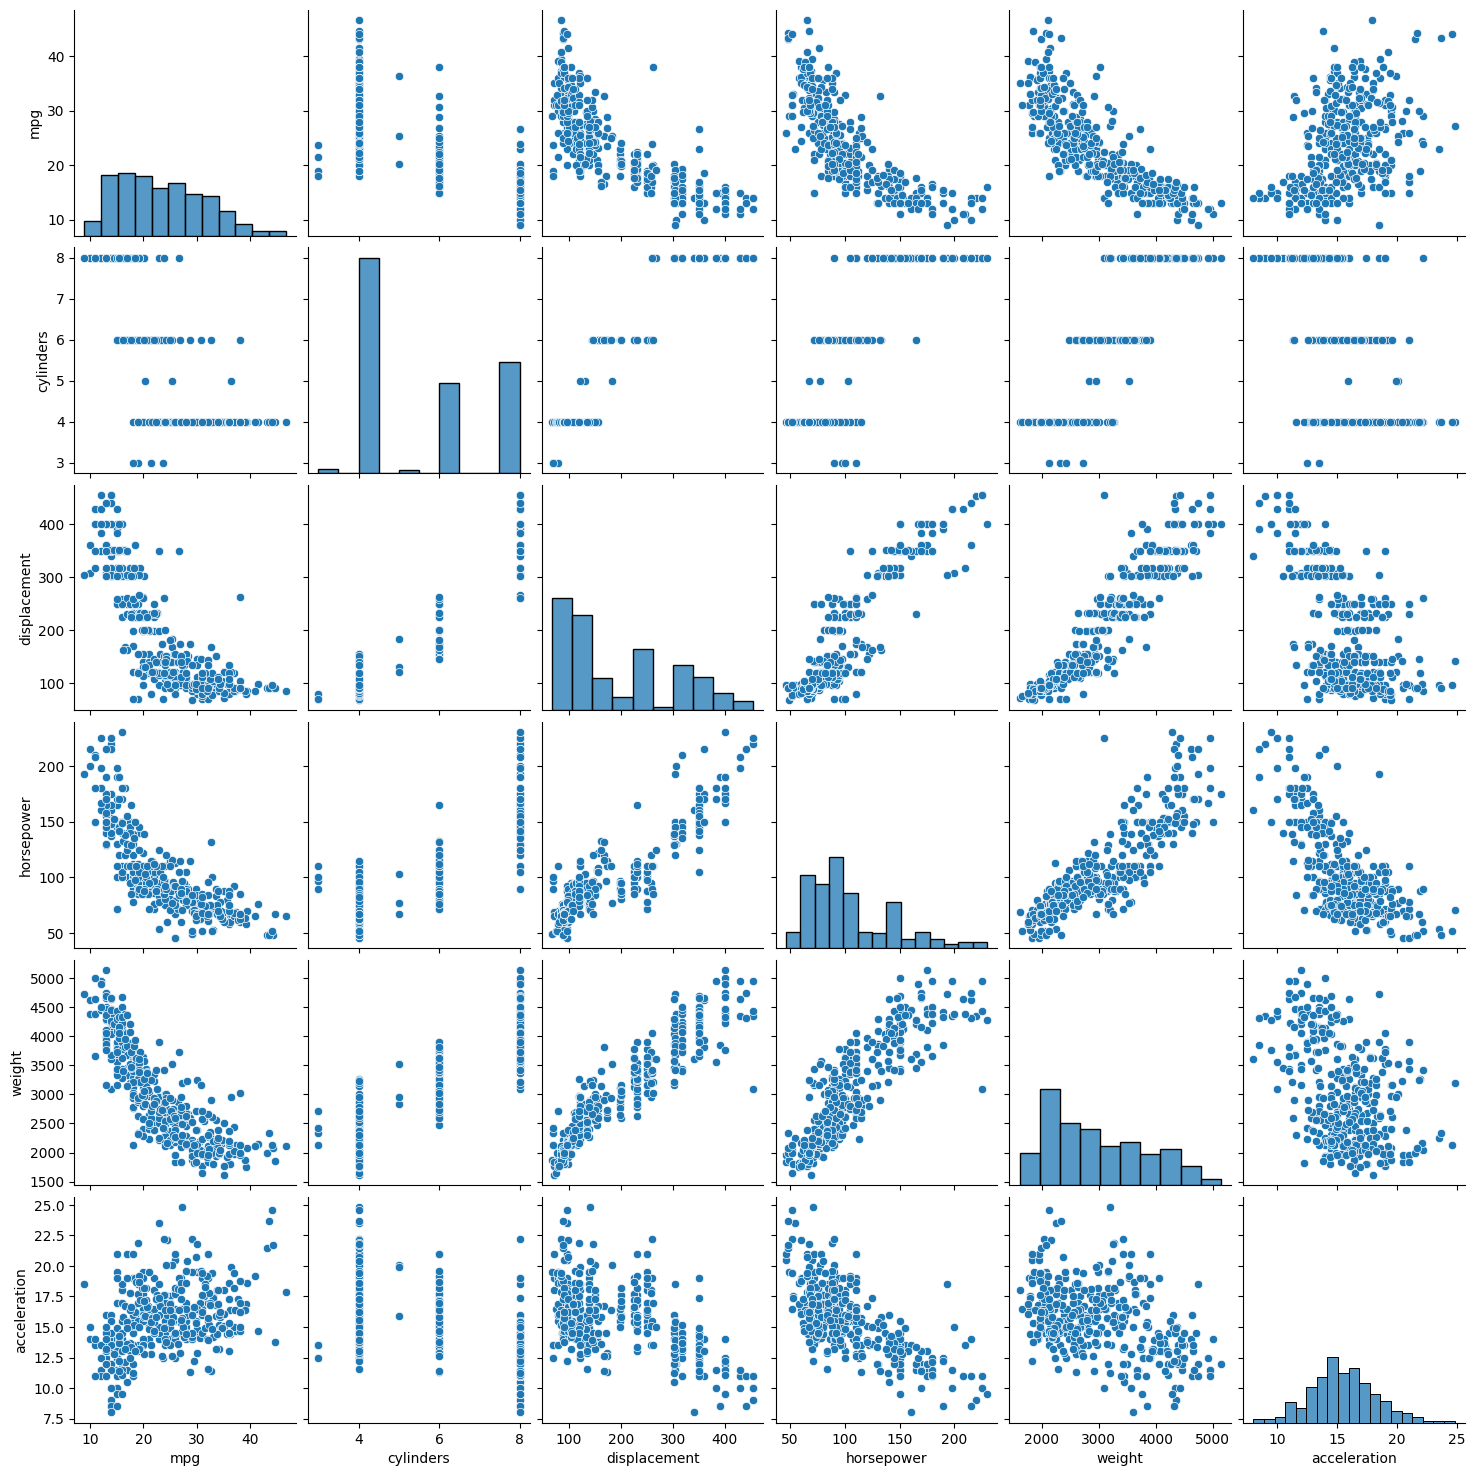

In [15]:
# Import seaborn for data visualization
import seaborn as sns

# pariplot columns
pairplot_columns = ["mpg", "cylinders", "displacement", 
                    "horsepower", "weight", "acceleration"]
# Visualize relations between feature pairs on a pairwise scatter plot
sns.pairplot(
    # Select all columns except encoded origins and model year
    dataset_encoded[pairplot_columns],
    diag_kind="hist"
)

In [16]:
# Use pandas describe features to see values like mean, standard deviation, etc.
# for the dataset
# Drop count column since we already know that from checking split sizes.
dataset_encoded.describe().drop(['count']).T

,mean,std,min,25%,50%,75%,max
mpg,23.445918,7.805007,9.0,17.000,22.75,29.000,46.6
cylinders,5.471939,1.705783,3.0,4.000,4.00,8.000,8.0
displacement,194.411990,104.644004,68.0,105.000,151.00,275.750,455.0
horsepower,104.469388,38.491160,46.0,75.000,93.50,126.000,230.0
weight,2977.584184,849.402560,1613.0,2225.250,2803.50,3614.750,5140.0
acceleration,15.541327,2.758864,8.0,13.775,15.50,17.025,24.8
model_year,75.979592,3.683737,70.0,73.000,76.00,79.000,82.0


In [17]:
# Normalize the dataset - we don't need to normalize 
# one-hot encoded features constructed from origin
normalized_columns = ["mpg", "cylinders", "displacement", 
         "horsepower", "weight", "acceleration"]
tmp = dataset_encoded.copy()[normalized_columns]
# Perform z-score normalization
# The result will be each feature with mean equal 
# (or at least very close) zero and standard deviation equal one
tmp = (tmp - tmp.mean()) / tmp.std()
# Assign a reference to a new variable to provide more readable name
dataset_normalized = tmp
dataset_normalized.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration
count,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02
mean,1.087565e-16,-7.250436e-17,-5.437827e-17,-1.631348e-16,3.625218e-17,4.350262e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.850853e+00,-1.449152e+00,-1.208019e+00,-1.519034e+00,-1.606522e+00,-2.733490e+00
25%,-8.258696e-01,-8.629108e-01,-8.544397e-01,-7.656144e-01,-8.857216e-01,-6.402369e-01
50%,-8.916306e-02,-8.629108e-01,-4.148541e-01,-2.849846e-01,-2.049490e-01,-1.497955e-02
75%,7.116049e-01,1.482053e+00,7.772830e-01,5.593651e-01,7.501341e-01,5.377842e-01
max,2.966568e+00,1.482053e+00,2.490234e+00,3.261284e+00,2.545808e+00,3.355973e+00


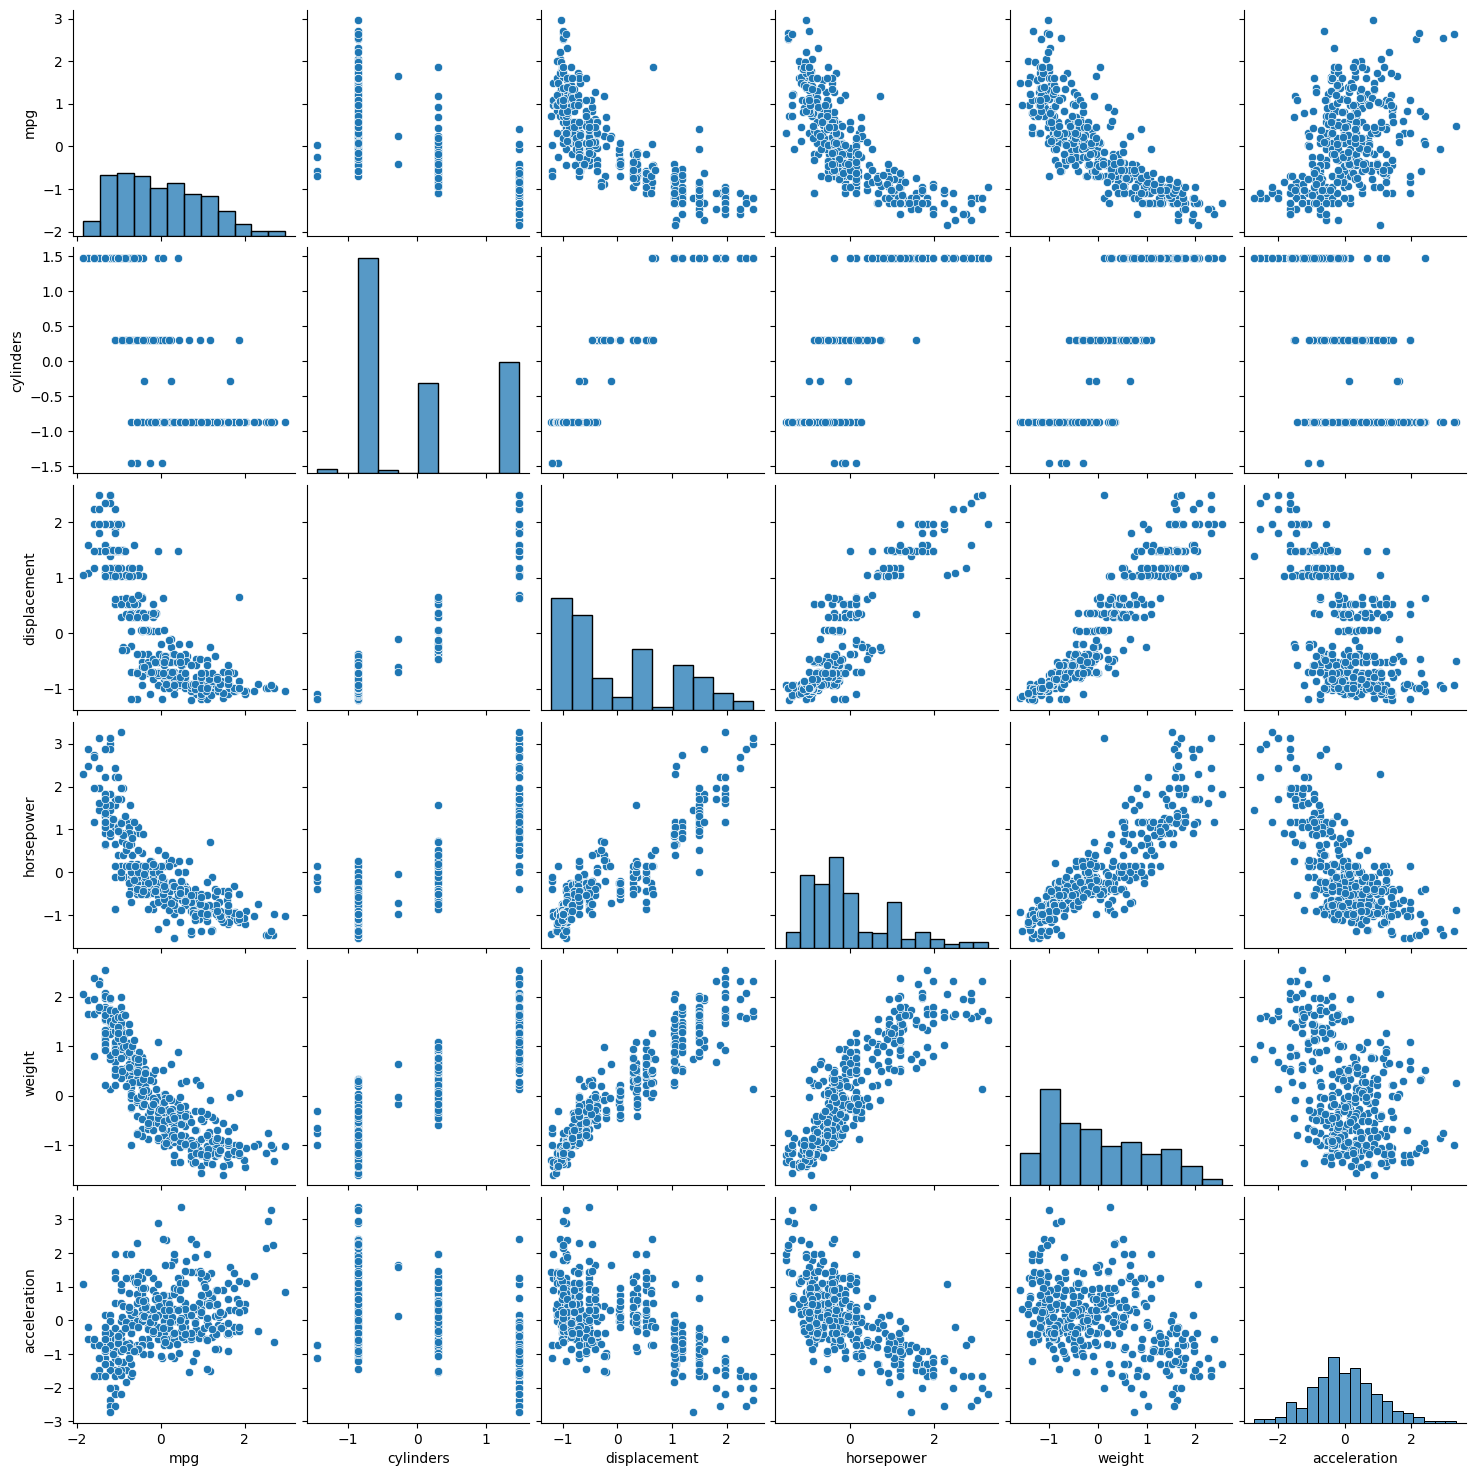

In [18]:
# Visualize normalized dataset on a pairplot
# The distribution of the data is maintained, but note the different
# min and max values on both x and y axis
sns.pairplot(
    # Select all columns except encoded origins and model year
    dataset_normalized[pairplot_columns],
    diag_kind="hist"
)

In [19]:
# Normalization using scikit-learn - for comparing results
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ds_normalized_sklearn = pd.DataFrame(
    scaler.fit_transform(dataset_encoded[normalized_columns]), 
    columns=normalized_columns
)
print(ds_normalized_sklearn.describe())
# We won't actually use those results so the variable is deleted
# to save memory
del ds_normalized_sklearn

                mpg     cylinders  displacement    horsepower        weight  \
count  3.920000e+02  3.920000e+02  3.920000e+02  3.920000e+02  3.920000e+02   
mean   1.450087e-16 -1.087565e-16 -7.250436e-17 -1.812609e-16 -1.812609e-17   
std    1.001278e+00  1.001278e+00  1.001278e+00  1.001278e+00  1.001278e+00   
min   -1.853218e+00 -1.451004e+00 -1.209563e+00 -1.520975e+00 -1.608575e+00   
25%   -8.269250e-01 -8.640136e-01 -8.555316e-01 -7.665929e-01 -8.868535e-01   
50%   -8.927701e-02 -8.640136e-01 -4.153842e-01 -2.853488e-01 -2.052109e-01   
75%    7.125143e-01  1.483947e+00  7.782764e-01  5.600800e-01  7.510927e-01   
max    2.970359e+00  1.483947e+00  2.493416e+00  3.265452e+00  2.549061e+00   

       acceleration  
count  3.920000e+02  
mean   4.350262e-16  
std    1.001278e+00  
min   -2.736983e+00  
25%   -6.410551e-01  
50%   -1.499869e-02  
75%    5.384714e-01  
max    3.360262e+00  


In [35]:
# Import sklearn train_test_split method
from sklearn.model_selection import train_test_split

# Define random state for reproducibility
seed = 2137
# Split dataset into training and test sets
dataset_train, dataset_test = train_test_split(dataset_normalized, 
                                               test_size=0.2,
                                               random_state=seed)
# Display sizes of entire dataset and two split sets
print(f"Entire dataset length: {len(dataset_encoded)}")
print(f"Training set length: {len(dataset_train)}")
print(f"Test set length: {len(dataset_test)}")

Entire dataset length: 392
Training set length: 313
Test set length: 79


# The model
First, we'll use a simple, one feature linear model to perform a very basic linear regression, utilizing scikit-learn library to do so.

In [28]:
# Import linear regression from scikit-learn
from sklearn.linear_model import LinearRegression

# Define input and target variables
y = dataset_train["mpg"]
y_reshaped = y.values.reshape(-1,1)
# Let's use car's weight to predict it's fuel usage
x_weight = dataset_train["weight"]
x_weight_reshaped = x_weight.values.reshape(-1,1)

# Define linear regression object
regressor = LinearRegression()

# Fit linear model
regressor.fit(X=x_weight_reshaped, y=y_reshaped)

# Predict values using trained linear model
y_pred = regressor.predict(x_weight_reshaped)
# Convert raw y_pred array into pandas dataframe
y_pred_series = pd.Series(y_pred.flatten(), name="mpg_predicted")

<AxesSubplot: xlabel='weight', ylabel='mpg'>

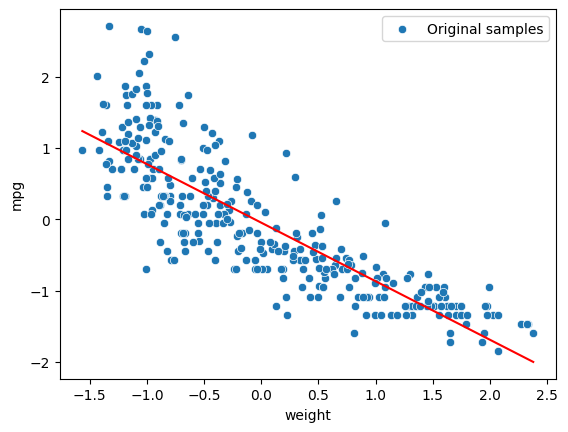

In [29]:
# Scatterplot with original data
sns.scatterplot(x=x_weight, y=y, label='Original samples')

# Line plot of predicted data
sns.lineplot(
    x=x_weight_reshaped.flatten(), 
    y=y_pred_series, 
    color='red'
)

In [30]:
# As a final matter - display regressor's score
# The closer to 1 the better
y_test = dataset_test["mpg"].values.reshape(-1,1)
x_weight_test = dataset_test["weight"].values.reshape(-1,1)
score = regressor.score(x_weight_test, y_test)
print("R-squared score:", score)

R-squared score: 0.6319326536223602


# Comparing regressors using different features
We'll use other features from the dataset to compare the linear regression's score - this way we'll find out the abillity of each selected feature to predict the target value.

In [31]:
# Define functions used to get R-squared scores for models using 
# different features

def predict_by_feature(feature_name: str) -> float:
    """Build single variable linear model based on selected feature.

    Args:
        feature_name (str): feature as column name in the dataset.

    Returns:
        float: R^2 score.
    """
    # Train
    y_train = dataset_train["mpg"].values.reshape(-1,1)
    x_train = dataset_train[feature_name].values.reshape(-1,1)
    regressor = LinearRegression()
    regressor.fit(X=x_train, y=y_train)
    # Test
    y_test = dataset_test["mpg"].values.reshape(-1,1)
    x_test = dataset_test[feature_name].values.reshape(-1,1)
    score = regressor.score(X=x_test, y=y_test)
    return score

In [32]:
features = ["cylinders", "displacement", "horsepower", 
            "weight", "acceleration"]
# Dictionary for keeping results
feature_score_map = {}

for column_name in features:
    score = predict_by_feature(column_name)
    print(f"{column_name} based model R^2 score: {score}")
    feature_score_map[column_name] = score

print("---------------------------------------------------------------")

max_feature = max(feature_score_map.items(), key= lambda x: x[1])
print(f"Best score was attained using {max_feature[0]} "
      f"with R-squared of: {max_feature[1]}")

cylinders based model R^2 score: 0.532542620575686
displacement based model R^2 score: 0.5974878365319427
horsepower based model R^2 score: 0.5949536227286917
weight based model R^2 score: 0.6319326536223602
acceleration based model R^2 score: 0.18442629491993345
---------------------------------------------------------------
Best score was attained using weight with R-squared of: 0.6319326536223602


# Multivariate linear model
In this variant we'll use all available features to try to predict the target variable - mpg.

In [49]:
# Prepare a clean copy of the dataset for this chapter

# Define random state for reproducibility
seed = 2137
# Split dataset into training and test sets
dataset_multivariate = dataset_normalized.copy()
ds_mv_train, ds_mv_test = train_test_split(dataset_multivariate, 
                                               test_size=0.2,
                                               random_state=seed)

y_train = ds_mv_train.pop("mpg").values.reshape(-1,1)
# Since we used pop, mpg column is no longer in the dataset, so we can
# just use the rest of ds_mv_train
# We'll use second element of shape property to get the columns number
x_train = ds_mv_train.values.reshape(-1, ds_mv_train.shape[1])

# Prepare test set
y_test = ds_mv_test.pop("mpg").values.reshape(-1,1)
x_test = ds_mv_test.values.reshape(-1, ds_mv_test.shape[1])


In [50]:
# Fit the linear model
regressor_mv = LinearRegression()
regressor_mv.fit(x_train, y_train)

# Training score
train_score = regressor_mv.score(X=x_train, y=y_train)
print(f"R-squared score on training dataset: {train_score}")
# Test set score
test_score = regressor_mv.score(X=x_test, y=y_test)
print(f"R-squared score on test dataset: {test_score}")


R-squared score on training dataset: 0.7141712033470635
R-squared score on test dataset: 0.6511825999731184
